In [2]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

#Max motor output
w_max = 100*2*math.pi/60
#timestep
ts = 0.001


class Arena:
   
  #constructor
  def __init__(self,size = [1000,1000], init_state = np.zeros(3),robotType = 'Paperbot', dt = 0.01):
    self.size = size
    #state = [x,y,theta(degrees),w]
    self.state = np.append(init_state,0.0)
        
    #Time scale
    self.time = dt
        
    #wheel angular velocities
    self.wR = 0.0
    self.wL = 0.0
    
    #input history
    self.wR_hist = []
    self.wL_hist = []    
    
    #state history
    self.x_hist = []
    self.y_hist = []
    self.theta_hist = []
    self.wc_hist = [] #angular velocity

    #Paperbot specs
    self.d = 50.0  #diameter of wheel (mm)
    self.W = 90.0 #width of robot (mm)
    self.R = self.d/2 #radius of wheel  
    self.lidar_disp_f = 25
    self.lidar_disp_r = 45
    self.lidar_noise_var = 25
    
    if (robotType == 'Segway'):
      #Segway Specs
      self.d = 502.0 #diameter of wheel (mm)
      self.W = 530.0  #width of robot (mm)
      self.R = self.d/2 #radius of wheel
      self.size = [10000,10000]
      self.lidar_disp_f = 250
      self.lidar_disp_r = 350
      self.lidar_noise_var = 250
    
    #oservation data
    self.front_laser = []
    self.right_laser = []
    self.gyro = []
    self.hx_sensor = []
    self.hy_sensor = []      

  #Convert pwm input to angular velocity
  def pwmToAngular(self,pwmValue = 0.0):

    if (pwmValue < 0.05 and pwmValue > -0.05):
      return 0
        
    elif (pwmValue > 0.3):
      return (0.5*(pwmValue-0.3)+0.3)*w_max
        
    elif (pwmValue < -0.3):
      return (0.5*(pwmValue+0.3)-0.3)*w_max
        
    else:
      return pwmValue*w_max
    
  #Uptadte state  
  def state_update(self, i = np.zeros(2),angular=False):
    #inputs
    self.wL = self.pwmToAngular(i[1])
    self.wR = self.pwmToAngular(i[0])
        
    #Using angular velocity as input instead of pwm 
    if angular == True:
      self.wL = i[1]
      self.wR = i[0]
        
    #Record Inputs
    self.wR_hist.append(self.wR)
    self.wL_hist.append(self.wL) 
    
    #current state
    x = self.state[0]
    y = self.state[1]
    theta = self.state[2]*math.pi/180
    
    #Record state history
    self.x_hist.append(self.state[0])
    self.y_hist.append(self.state[1])
    self.theta_hist.append(theta)
    self.wc_hist.append(self.state[3])  
    
    #Time Scale
    T = self.time
    
    #State update equation
    self.state[0] = x + 0.5*self.R*T*self.wR*math.cos(theta) + 0.5*self.R*T*self.wL*math.cos(theta)
    self.state[1] = y + 0.5*self.R*T*self.wR*math.sin(theta) + 0.5*self.R*T*self.wL*math.sin(theta)
    self.state[2] = ((180/math.pi)*(theta + self.R*T*self.wR/self.W - self.R*T*self.wL/self.W))%360
    self.state[3] = (self.wR*self.R - self.wL*self.R)/self.W
    
    #check out of bounds
    if (self.state[0] > self.size[0]):
      self.state[0] = self.size[0]

    if (self.state[0] < 0):
      self.state[0] = 0
            
    if (self.state[1] > self.size[1]):
      self.state[1] = self.size[1]
            
    if (self.state[1] < 0):
      self.state[1] = 0
  
        
    
  #Calculate euclidean distance from current state to coord = (x,y)
  def distance(self,coord = [0,0]):
    x_dist = (coord[0] - self.state[0])**2
    y_dist = (coord[1] - self.state[1])**2
    return (x_dist + y_dist)**(.5)
    
  #check if coord = (x,y) is inside the boundries
  def check_in(self,coord = [0,0]):
    if (coord[0] < 0 or coord[0] > self.size[0]):
      return False
    if (coord[1] < 0 or coord[1] > self.size[1]):
      return False
    return True
  
    
  #returns the observation; [df,dr,wc,hx,hy]
  def observation(self):
    #angle in radians
    theta = self.state[2]*math.pi/180
    tf = math.tan(theta)
    tr = math.tan(theta - (math.pi)/2)
    Width = self.size[0];
    Height = self.size[1];
    x0 = self.state[0];
    y0 = self.state[1];
    
    #df and dr as specified in the doc
    df = -1
    dr = -1
    # Case theta = 0
    if theta == 0:
      df = Width - x0
      dr = y0
    # Case theta = 90 degrees
    elif theta == (math.pi)/2:
      df = Height - y0
      dr = Width - x0
    # Case theta = 180 degrees  
    elif theta == math.pi:
      df = x0
      dr = Height - y0
    #Case theta = 270 degrees
    elif theta == 3*(math.pi)/2:
      df = y0
      dr = x0
    #Case 0<theta<90
    elif theta < math.pi/2:
      y = tf*(Width - x0) + y0
      if self.check_in([Width, y]) == True:
        df = self.distance([Width, y])
      else:
        x = x0 + (Height - y0)/tf
        df = self.distance([x, Height])
      y = tr*(Width - x0) + y0
      if self.check_in([Width, y]) == True:
        dr = self.distance([Width, y])
      else:
        x = x0 - (y0)/tr
        dr = self.distance([x, 0])
                
    #Case 90<theta<180
    elif theta < math.pi:
      y = tf*(0 - x0) + y0
      if self.check_in([0, y]) == True:
        df = self.distance([0, y])
      else:
        x = x0 + (Height - y0)/tf
        df = self.distance([x, Height])
      y = tr*(Width - x0) + y0
      if self.check_in([Width, y]) == True:
        dr = self.distance([Width, y])
      else:
        x = x0 + (Height - y0)/tr
        dr = self.distance([x, Height])
           
    #Case 180<theta<270
    elif theta < 3*math.pi/2:
      y = tf*(0 - x0) + y0
      if self.check_in([0, y]) == True:
        df = self.distance([0, y])
      else:
        x = x0 + (0 - y0)/tf
        df = self.distance([x, 0])
      y = tr*(0 - x0) + y0
      if self.check_in([0, y]) == True:
        dr = self.distance([0, y])
      else:
        x = x0 + (Height - y0)/tr
        dr = self.distance([x, Height])
                
    #Case 270<theta<360
    elif theta < 2*math.pi:
      y = tf*(Width - x0) + y0
      if self.check_in([Width, y]) == True:
        df = self.distance([Width, y])
      else:
        x = x0 + (0 - y0)/tf
        df = self.distance([x, 0])
      y = tr*(0 - x0) + y0
      if self.check_in([0, y]) == True:
        dr = self.distance([0, y])
      else:
        x = x0 - (y0)/tr
        dr = self.distance([x, 0])
        
    #Add noise to lidar readings
    df = df+np.random.normal(0,0.05*df) - self.lidar_disp_f
    dr = dr+np.random.normal(0,0.05*dr) - self.lidar_disp_r

    # angular rate (measured by gyro - with noise)
    wC = (self.wR*self.R - self.wL*self.R)/self.W
    wC = wC + np.random.normal(0,abs(0.05*wC))
    
    #magnetic field components
    Hx = math.cos(theta)
    Hx = Hx + np.random.normal(0,abs(0.05*Hx))
    Hy = math.sin(theta)
    Hy = Hy + np.random.normal(0,abs(0.05*Hy))
    self.front_laser.append(df)
    self.right_laser.append(dr)
    self.gyro.append(wC)
    self.hx_sensor.append(Hx)
    self.hy_sensor.append(Hy)   

  def get_state(self):
    return self.state

  #Return points on a line between (st,a1) and (et,a2)
  def interpolate(self,st = 0,et = 1, a1=0 , a2=0):
    w_inputs = []
    ts = self.time
    #linear equation
    m = (a2 - a1)/(et - st)
    t = st
    while t < et:
      #calculate w at time t
      w = m*(t - st) + a1
      w_inputs.append(w)
      t += ts
    return w_inputs

  #Run simulation given set of inputs. Record state and observation
  def simulate(self,table=[]):
    #table[i] = [time[i], inputR[i], inputL[i]] from the CAD JPG
    for i in range(0,len(table)-1):
      R = self.interpolate(table[i][0], table[i + 1][0], table[i][1], table[i + 1][1])
      L = self.interpolate(table[i][0], table[i + 1][0], table[i][2], table[i + 1][2])
      for j in range(0, len(R)):
        wr = R[j]*math.pi/180
        wl = L[j]*math.pi/180
        self.observation()
        self.state_update([wr, wl],angular = True)

  #Plot trajectory
  def plot_state(self):
    plt.scatter(self.x_hist,self.y_hist)
    plt.xlabel('x(mm)')
    plt.ylabel('y(mm)')
    plt.title('Python Simulation Displacement')
    #plt.xlim([0,self.size[0]])
    #plt.ylim([0,self.size[1]])
    plt.grid(True)

  #Return the current observation
  def get_observation(self):
    o=[]
    o.append(self.front_laser)
    o.append(self.right_laser)
    o.append(self.gyro)
    o.append(self.hx_sensor)
    o.append(self.hy_sensor)
    return o
    
  #Export motor inports and sensor outputs 
  def export_csv(self,inputname='inputs.csv',outputname='outputs.csv'):
      #inputs
      data = {'wR': self.wR_hist,
              'wL': self.wL_hist}
      df = pd.DataFrame (data, columns = ['wR','wL'])
      #put your file path and name here
      df.to_csv(inputname, index = False)
      
        
      #outputs
      data = {'x': self.x_hist,
              'y': self.y_hist,
              'theta': self.theta_hist,
              'wc': self.wc_hist,
              'df': self.front_laser,
              'dr': self.right_laser,
              'gyro': self.gyro,
              'hx': self.hx_sensor,
              'hy': self.hy_sensor}
      df = pd.DataFrame (data, columns = ['x','y','theta','wc','df','dr','gyro','hx','hy'])
      #put your file path and name here
      df.to_csv(outputname, index = False)

  #Return angular velocity ground truth  
  def getwc(self):
        return self.wc_hist


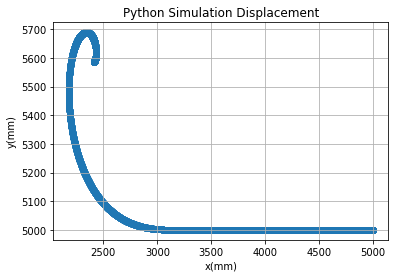

In [3]:
#Segway
Arena1 = Arena(size = [10000,10000],init_state = [5000,5000,180], robotType='Segway',dt = 0.001)
table_segway_circle=[[0,0,0],[2,400,400],[4,-400,400],[5,0,0]]
Arena1.simulate(table = table_segway_circle)
Arena1.plot_state()
Arena1.export_csv(inputname=r'C:\Users\giaco\Documents\MATLAB\EE183\lab3\inputs.csv',outputname=r'C:\Users\giaco\Documents\MATLAB\EE183\lab3\outputs.csv')

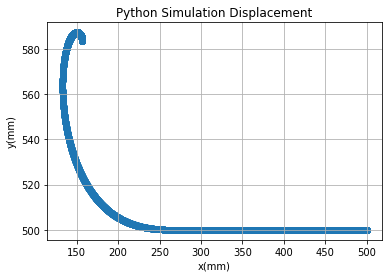

In [21]:
#paperBot
Arena2= Arena(init_state=[500,500,180],robotType = 'PaperBot', dt=0.001)
paperbot_table=[[0,0,0],[2,500,500],[4,-500,500],[5,0,0]]
Arena2.simulate(paperbot_table)
Arena2.plot_state()
Arena2.export_csv(inputname=r'C:\Users\giaco\Documents\MATLAB\EE183\lab3\inputs.csv',outputname=r'C:\Users\giaco\Documents\MATLAB\EE183\lab3\outputs.csv')